# Import Libraries

In [2]:
import tensorflow as tf

import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

tf.__version__

'2.10.1'

# Create Data

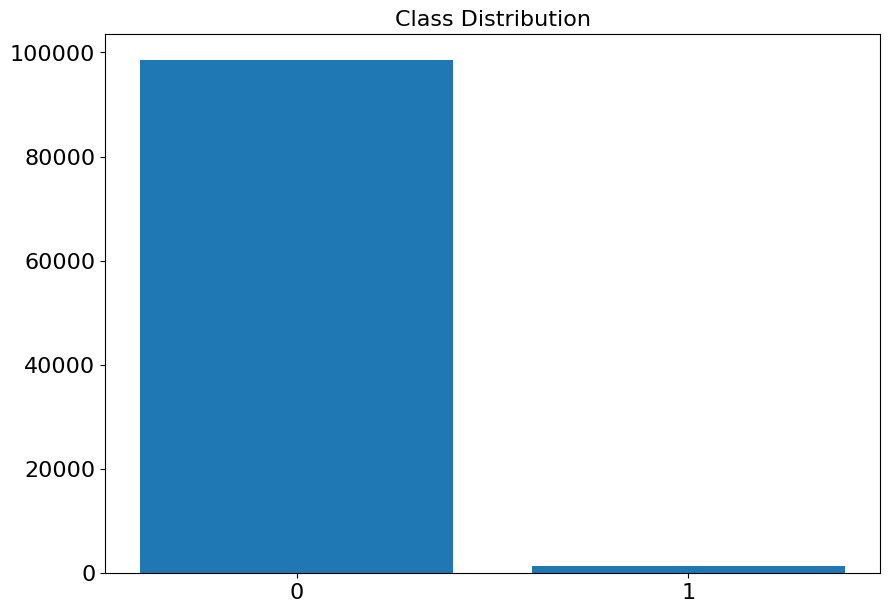

In [3]:
X, y = make_classification(n_samples = 100000,
                           n_features= 10,
                           n_classes= 2,
                           weights= [0.99, 0.01],
                           n_redundant = 0)

unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(10,7))
plt.bar(unique, counts)

plt.xticks(unique, fontsize = 16)
plt.yticks(fontsize = 16)
plt.title("Class Distribution", fontsize = 16)

plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size= 0.2 , stratify= y , random_state= 53)

In [5]:
class_weights = compute_class_weight(class_weight= 'balanced',
                                     classes = [0, 1], # classes = np.unique(y_train)
                                     y = y_train)

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5072987609227765, 1: 34.75238922675934}

# Models

In [6]:
input_layer = tf.keras.Input(shape=(X.shape[1],))

x = tf.keras.layers.Dense(64)(input_layer)
x = tf.nn.relu(x)

x = tf.keras.layers.Dense(32)(x)
x = tf.nn.relu(x)

x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(1)(x)
x = tf.keras.layers.Activation("sigmoid")(x)


base_model = tf.keras.models.Model(input_layer, x)
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33    

In [7]:
# base_model(np.expand_dims(X_train[0] ,axis = 0)) # You can call this way.

In [8]:
base_model.get_weights()

[array([[-9.70271230e-03, -1.40596285e-01,  2.34953433e-01,
         -2.52574980e-01, -3.36275697e-02,  2.32955009e-01,
          4.72059250e-02, -1.08968750e-01, -5.08068949e-02,
          5.49819171e-02, -1.07339606e-01,  1.74484879e-01,
          1.72162950e-01,  2.63536066e-01, -3.83940488e-02,
          2.80253619e-01, -1.64512187e-01, -1.60035491e-03,
         -1.10410705e-01,  2.64425248e-01,  2.43144065e-01,
         -4.88453656e-02, -2.75680602e-01,  2.61161029e-02,
         -2.07351208e-01,  1.32316679e-01,  2.35888451e-01,
          1.79418862e-01, -1.60548419e-01,  4.11699116e-02,
          1.20817572e-01, -2.76718497e-01,  8.10914636e-02,
         -1.24829739e-01,  9.25541818e-02, -1.96107090e-01,
         -8.35102797e-02, -1.80555254e-01, -2.31449306e-01,
          5.30472398e-02, -8.83296579e-02, -8.02665949e-04,
          1.63622350e-01,  1.12616420e-01,  2.61609167e-01,
          7.96136558e-02, -1.31003574e-01, -1.02024242e-01,
         -2.12814853e-01, -6.27625585e-0

In [9]:
base_model.save_weights("initial_weights.h5")

In [10]:
class_weight_model = tf.keras.models.clone_model(base_model)
focal_loss_model = tf.keras.models.clone_model(base_model)
cat_focal_loss_model = tf.keras.models.clone_model(base_model)

In [11]:
base_model.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = [tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall()])

In [12]:
history = base_model.fit(X_train, y_train, epochs = 32, batch_size=128, validation_split=0.2)

Epoch 1/32
500/500 [==============================] - 2s 2ms/step - loss: 0.0896 - precision: 0.0097 - recall: 0.0022 - val_loss: 0.0645 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/32
500/500 [==============================] - 1s 2ms/step - loss: 0.0644 - precision: 0.7273 - recall: 0.0344 - val_loss: 0.0622 - val_precision: 0.5667 - val_recall: 0.0766
Epoch 3/32
500/500 [==============================] - 1s 2ms/step - loss: 0.0616 - precision: 0.6412 - recall: 0.1173 - val_loss: 0.0603 - val_precision: 0.5510 - val_recall: 0.1216
Epoch 4/32
500/500 [==============================] - 1s 2ms/step - loss: 0.0602 - precision: 0.6413 - recall: 0.1539 - val_loss: 0.0585 - val_precision: 0.6154 - val_recall: 0.1441
Epoch 5/32
500/500 [==============================] - 1s 2ms/step - loss: 0.0581 - precision: 0.6774 - recall: 0.1808 - val_loss: 0.0560 - val_precision: 0.5968 - val_recall: 0.1667
Epoch 6/32
500/500 [==============================] - 1s 2ms/step - loss: 0.0557 -

In [13]:
base_model.evaluate(X_test, y_test)

625/625 [==============================] - 1s 1ms/step - loss: 0.0516 - precision: 0.7241 - recall: 0.2917


[0.05155213177204132, 0.7241379022598267, 0.2916666567325592]

In [14]:
preds = base_model.predict(X_test)

625/625 [==============================] - 0s 568us/step


In [15]:
threshold = 0.5
y_pred = np.where(preds >= threshold , 1 , 0)

print(classification_report(y_test,  y_pred))
print(confusion_matrix(y_test,  y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19712
           1       0.72      0.29      0.42       288

    accuracy                           0.99     20000
   macro avg       0.86      0.65      0.70     20000
weighted avg       0.99      0.99      0.99     20000

[[19680    32]
 [  204    84]]


In [16]:
threshold = 0.1
y_pred = np.where(preds >= threshold , 1 , 0)

print(classification_report(y_test,  y_pred))
print(confusion_matrix(y_test,  y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19712
           1       0.37      0.47      0.41       288

    accuracy                           0.98     20000
   macro avg       0.68      0.73      0.70     20000
weighted avg       0.98      0.98      0.98     20000

[[19478   234]
 [  152   136]]


# 2.Model

In [17]:
class_weight_model.load_weights("initial_weights.h5")

In [18]:
class_weights

{0: 0.5072987609227765, 1: 34.75238922675934}

In [19]:
class_weight_model.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = [tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall()])


history_cw = class_weight_model.fit(X_train, y_train, 
                         epochs = 32, 
                         batch_size= 128, 
                         validation_split= 0.2,
                         class_weight= class_weights)
                        # class_weight= {0: 0.5, 1: 32.948929159802304})

Epoch 1/32
500/500 [==============================] - 1s 2ms/step - loss: 0.5584 - precision_1: 0.0430 - recall_1: 0.6383 - val_loss: 0.4697 - val_precision_1: 0.0542 - val_recall_1: 0.6892
Epoch 2/32
500/500 [==============================] - 1s 2ms/step - loss: 0.4997 - precision_1: 0.0602 - recall_1: 0.6760 - val_loss: 0.4580 - val_precision_1: 0.0672 - val_recall_1: 0.6577
Epoch 3/32
500/500 [==============================] - 1s 2ms/step - loss: 0.4917 - precision_1: 0.0689 - recall_1: 0.6792 - val_loss: 0.4290 - val_precision_1: 0.0738 - val_recall_1: 0.6216
Epoch 4/32
500/500 [==============================] - 1s 2ms/step - loss: 0.4869 - precision_1: 0.0728 - recall_1: 0.6685 - val_loss: 0.4584 - val_precision_1: 0.0704 - val_recall_1: 0.6532
Epoch 5/32
500/500 [==============================] - 1s 2ms/step - loss: 0.4785 - precision_1: 0.0749 - recall_1: 0.6738 - val_loss: 0.4562 - val_precision_1: 0.0800 - val_recall_1: 0.6216
Epoch 6/32
500/500 [==============================

In [20]:
preds = base_model.predict(X_test)

625/625 [==============================] - 0s 546us/step


In [21]:
threshold = 0.5
y_pred = np.where(preds >= threshold , 1 , 0)

print(classification_report(y_test,  y_pred))
print(confusion_matrix(y_test,  y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19712
           1       0.72      0.29      0.42       288

    accuracy                           0.99     20000
   macro avg       0.86      0.65      0.70     20000
weighted avg       0.99      0.99      0.99     20000

[[19680    32]
 [  204    84]]


In [22]:
threshold = 0.1
y_pred = np.where(preds >= threshold , 1 , 0)

print(classification_report(y_test,  y_pred))
print(confusion_matrix(y_test,  y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19712
           1       0.37      0.47      0.41       288

    accuracy                           0.98     20000
   macro avg       0.68      0.73      0.70     20000
weighted avg       0.98      0.98      0.98     20000

[[19478   234]
 [  152   136]]


In [23]:
threshold = 0.02
y_pred = np.where(preds >= threshold , 1 , 0)

print(classification_report(y_test,  y_pred))
print(confusion_matrix(y_test,  y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     19712
           1       0.13      0.64      0.22       288

    accuracy                           0.93     20000
   macro avg       0.56      0.79      0.59     20000
weighted avg       0.98      0.93      0.95     20000

[[18501  1211]
 [  104   184]]


In [24]:
# Done for now

# Categorical Focal Loss

In [25]:
y_pred = [[0.1] , [0.8]]
y_true = [[0] , [0]]

tf.keras.losses.BinaryFocalCrossentropy(reduction='none')(y_true, y_pred) # Focal loss focusing wrong guesses. And punished so much. Like mse lol.

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.0010536, 1.03004  ], dtype=float32)>

In [26]:
# tf.reduce_mean([0.0010536, 1.03004])                    # np.array([0.0010536 , 1.03004]).mean()

In [27]:
y_pred = [[0.1] , [0.8]]
y_true = [[0] , [0]]

tf.keras.losses.BinaryCrossentropy(reduction='none')(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.10536041, 1.6094375 ], dtype=float32)>

In [28]:
y_pred = [[0.1] , [0.8]]
y_true = [[0] , [0]]

tf.keras.losses.BinaryFocalCrossentropy(alpha=1 , gamma = 0 , reduction='none')(y_true, y_pred)  # alpha and gamma parameters is so important. if alpha = 1 , gamma = 0 equal to BinaryCrossentropy.
                                                                                                                                             # if alpha = 0.25 , gamma = 2.0 equal to BinaryFocalCrossentropy

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.10536041, 1.6094375 ], dtype=float32)>

In [72]:
class CategoricalFocalCE(tf.keras.losses.Loss): # LossFunctionWrapper
    def __init__(self, alpha = 0.25, gamma = 2.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma
    
    def call(self , y_true , y_pred):
        # y_true = tf.convert_to_tensor(y_true , dtype = tf.float32)
        y_true = tf.cast(y_true , dtype = tf.float32)
        # y_pred = tf.convert_to_tensor(y_pred , dtype = tf.float32)
        y_pred = tf.cast(y_pred , dtype = tf.float32)
        
        # Objective maximize to likelihood.
        # If we work with negative likelihood, we should minimize the -likelihood.
        # We want to change multiply to add. We will use log-likelihood
        # -log-likelihood   -->  negative log-likelihood
        
        y_pred = tf.clip_by_value(y_pred, 
                                  tf.keras.backend.epsilon(), 
                                  1-tf.keras.backend.epsilon())
        
        cce = -y_true * tf.math.log(y_pred) # Crossentropy
        
        # gamma is focusing parameter.
        modulating_factor = tf.pow(1-y_pred , self.gamma)  
        
        # alpha weighting parameter 
        weighting_factor = tf.multiply(self.alpha, modulating_factor)
        
        # Focal Loss
        focal_loss = tf.multiply(weighting_factor, cce)
        
        return focal_loss # return tf.recuce_mean(tf.reduce.sum(focal_loss, axis= -1))

In [73]:
tf.clip_by_value([[0 , 0.9]], tf.keras.backend.epsilon(), 1-tf.keras.backend.epsilon())

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1.e-07, 9.e-01]], dtype=float32)>

In [74]:
y_pred = [[0.1, 0.9] , [0.8, 0.2]]
y_true = [[0,1] , [0,1]]

In [75]:
cfce = CategoricalFocalCE(alpha= [0.5 , 33.0] , gamma = 2 , reduction = 'none') # reduction = 'none' is a parameter which works with **kwargs and it shows every punishment 
                                                                                # If gamma reduce, You increase the punishment which you know in data.
cfce(y_true , y_pred)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.      ,  0.034769],
       [ 0.      , 33.99133 ]], dtype=float32)>

In [76]:
tf.reduce_mean(tf.reduce_sum([[0.       , 0.0002634],
       [0.       , 0.2575101]], axis = -1))

<tf.Tensor: shape=(), dtype=float32, numpy=0.12888674>

In [101]:
input_layer = tf.keras.Input(shape=(X.shape[1],))

x = tf.keras.layers.Dense(64)(input_layer)
x = tf.nn.relu(x)

x = tf.keras.layers.Dense(32)(x)
x = tf.nn.relu(x)

x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(2)(x)
x = tf.keras.layers.Activation("softmax")(x)


categorical_focal_model = tf.keras.models.Model(input_layer, x)
categorical_focal_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_18 (Dense)            (None, 64)                704       
                                                                 
 tf.nn.relu_12 (TFOpLambda)  (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 tf.nn.relu_13 (TFOpLambda)  (None, 32)                0         
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 2)                 66  

In [102]:
categorical_focal_model.compile(optimizer = 'adam',
                   loss = CategoricalFocalCE(alpha = [0.5, 33.0],
                                             gamma = 2.0),
                   metrics = [tf.keras.metrics.Precision(class_id = 1),
                              tf.keras.metrics.Recall(class_id = 1)])

In [103]:
y_train_ohe = tf.keras.utils.to_categorical(y_train,2)

history = categorical_focal_model.fit(X_train, y_train_ohe, epochs = 64, batch_size=128, validation_split=0.2)

Epoch 1/64
500/500 [==============================] - 1s 2ms/step - loss: 0.0691 - precision_7: 0.0425 - recall_7: 0.6598 - val_loss: 0.0622 - val_precision_7: 0.0671 - val_recall_7: 0.6126
Epoch 2/64
500/500 [==============================] - 1s 2ms/step - loss: 0.0628 - precision_7: 0.0654 - recall_7: 0.6534 - val_loss: 0.0617 - val_precision_7: 0.0774 - val_recall_7: 0.6036
Epoch 3/64
500/500 [==============================] - 1s 2ms/step - loss: 0.0611 - precision_7: 0.0757 - recall_7: 0.6523 - val_loss: 0.0611 - val_precision_7: 0.0669 - val_recall_7: 0.6171
Epoch 4/64
500/500 [==============================] - 1s 2ms/step - loss: 0.0603 - precision_7: 0.0770 - recall_7: 0.6502 - val_loss: 0.0617 - val_precision_7: 0.0902 - val_recall_7: 0.5811
Epoch 5/64
500/500 [==============================] - 1s 2ms/step - loss: 0.0594 - precision_7: 0.0792 - recall_7: 0.6663 - val_loss: 0.0602 - val_precision_7: 0.0790 - val_recall_7: 0.6622
Epoch 6/64
500/500 [==============================

In [104]:
preds = categorical_focal_model.predict(X_test)
preds

625/625 [==============================] - 1s 777us/step


array([[0.9339436 , 0.06605638],
       [0.80724615, 0.19275391],
       [0.75660473, 0.24339531],
       ...,
       [0.79793024, 0.20206973],
       [0.52278113, 0.47721884],
       [0.90780574, 0.09219427]], dtype=float32)

In [105]:
# np.argmax(preds, axis= -1)

In [106]:
# y_test_ohe = tf.keras.utils.to_categorical(y_test , 2)

In [107]:
preds_classes = np.argmax(preds, axis= -1)
print(classification_report(y_test, preds_classes, digits= 4))
print(confusion_matrix(y_test, preds_classes))

              precision    recall  f1-score   support

           0     0.9929    0.8952    0.9415     19712
           1     0.0727    0.5625    0.1288       288

    accuracy                         0.8904     20000
   macro avg     0.5328    0.7289    0.5352     20000
weighted avg     0.9797    0.8904    0.9298     20000

[[17647  2065]
 [  126   162]]


In [ ]:
# Done for now.